# Testing the coefficients in a real simulation where the feedback is generated by the readout.

In [1]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

# plt.rcParams['figure.figsize'] = 5, 10

import numpy
import sys
import os

import save_load_file as slf

In [2]:
import matplotlib 

# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

# matplotlib.rcdefaults() # restores to the default values

# http://matplotlib.org/api/matplotlib_configuration_api.html#matplotlib.rc

# Main functions to the 2 joint arm simulation

In [3]:
from simulation_2DoF_Arm_physics import *
reload(sys.modules['simulation_2DoF_Arm_physics']) # Makes sure the interpreter is going to reload the module

<module 'simulation_2DoF_Arm_physics' from 'simulation_2DoF_Arm_physics.pyc'>

#Start of the simulation!

In [4]:
trajectories = [[[0.75,0.25],[0.0,0.5]],\
                [[0.25,0.60],[-0.25,0.60]],\
                [[-0.10,0.75],[-0.10,0.25]],\
                [[-0.75,0.50],[-0.40,0.00]]]

In [5]:
# First the arm parametres according to Joshi/Maass paper
aparams = {
    'l1' : 0.5, # metres
    'l2' : 0.5,
    'lc1' : 0.25,
    'lc2' : 0.25,
    'm1' : 1.0, # kg
    'm2' : 1.0,
    'i1' : 0.03, # kg*m*m
    'i2' : 0.03
}

In [6]:
# Total time spent during the movement (in seconds)
MT = 0.5
# Simulation time step (in seconds)
time_step = 2/1000.0
# Number of neurons at each input layer (defines the resolution of the system)
Ninput = 50

In [7]:
t_mov=numpy.arange(0, MT, time_step) # t starts in 0s and steps time_step(s) until reaches MT(s)

In [11]:
sim_set = "set_01"
sim_set_name = "Set B"
total_trials = 50

base_dir = "2DofArm_simulation_data"

# Reads all the experiments to check which range of torques is necessary to control the arm
# These values are based ONLY in the 4 trajectories used!
torques_all_1 = numpy.array([]);
torques_all_2 = numpy.array([]);
number_of_trajectories = len(trajectories)
for i in range(1,number_of_trajectories+1):
    states,torques = slf.load_from_file_gz("./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(i)+".gzpickle")
    torques_all_1 = numpy.concatenate((torques_all_1,torques[:,0])) # torques joint 1
    torques_all_2 = numpy.concatenate((torques_all_2,torques[:,1])) # torques joint 2

In [12]:
# Creates the 50 possible discrete values of torques for each joint (probably will be different)
torques_values_1=numpy.linspace(torques_all_1.min(),torques_all_1.max(),num=50)
torques_values_2=numpy.linspace(torques_all_2.min(),torques_all_2.max(),num=50)

In [13]:
# Creates the 50 possible discrete values of angles for each joint
teta1_values=numpy.linspace(-numpy.pi/6,numpy.pi,num=50)
teta2_values=numpy.linspace(0,numpy.pi,num=50)

In [14]:
# These are the 50 possible values that the input neurons will represent (x,y) 
x_values=numpy.linspace(-1,1,num=50)
y_values=numpy.linspace(-1,1,num=50)

In [15]:
def generates_lsm_start(tji):
    xstart,ystart = trajectories[tji-1][0]
    xdest,ydest = trajectories[tji-1][1]


    # The original system, proposed by Joshi/Maass 2006 starts without any information about the current
    # position because the proprioceptive feedback comes only after a time delay.

    # Now I will add some noise
    # noise_sd = 0.1
    # xstart,ystart = xstart+numpy.random.normal(loc=0,scale=noise_sd),ystart+numpy.random.normal(loc=0,scale=noise_sd)
    # xdest,ydest = xdest+numpy.random.normal(loc=0,scale=noise_sd),ydest+numpy.random.normal(loc=0,scale=noise_sd)

    # print "Original:", trajectories[tji-1][0],trajectories[tji-1][1]
    # print "Noisy:",[xstart,ystart],[xdest,ydest]


    # Indexes of the normalized initial position values to use in the LSM simulation
    xstart_idx =  abs(x_values-xstart).argmin()
    ystart_idx =  abs(y_values-ystart).argmin()

    # Indexes of the normalized final position values to use in the LSM simulation
    xdest_idx =  abs(x_values-xdest).argmin()
    ydest_idx =  abs(y_values-ydest).argmin()

    (xstart_idx,ystart_idx),(xdest_idx,ydest_idx)


    # The input (one big neurongroup with 300 neurons) will be divided like this:
    # 6 groups of 50 neurons.
    # - Group 1: xdest => offset:0
    # - Group 2: ydest => offset:50
    # - Group 3: teta1 => offset:100
    # - Group 4: teta2 => offset:150
    # - Group 5: tau1  => offset:200
    # - Group 6: tau2  => offset:250

    ############# Using ONLY the initial (start) position
    # x_lsm = xstart_idx + 0
    # y_lsm = ystart_idx + 50

    ############# Using ONLY the final (dest) position
    x_lsm = xdest_idx + 0
    y_lsm = ydest_idx + 50
    return x_lsm,y_lsm,xstart,ystart,xdest,ydest

## Measuring the difference between the generated curves
$MeanDistance=\frac{1}{N} \sum \limits_{n=1}^{N}  \lVert P_{Ideal}(n)-P_{Test}(n) \rVert$

$TotalLength=\sum \limits_{n=1}^{N}  \lVert P_{Ideal}(n)-P_{Ideal}(n-1) \rVert$

$NCE=\frac{MeanDistance}{TotalLength}$

In [16]:
def MY_METRIC(vec_orig,vec):
    
    # First I calculate the mean distance between all the (x,y) points
    mean_distance=(numpy.sqrt(((vec_orig-vec)**2).sum(axis=0).mean()))
    
    # Then the line integral (the length of the curve)
    line_integral=(numpy.sqrt(((vec_orig.T[1:]-vec_orig.T[:-1])**2).sum(axis=1))).sum()

    return mean_distance/line_integral

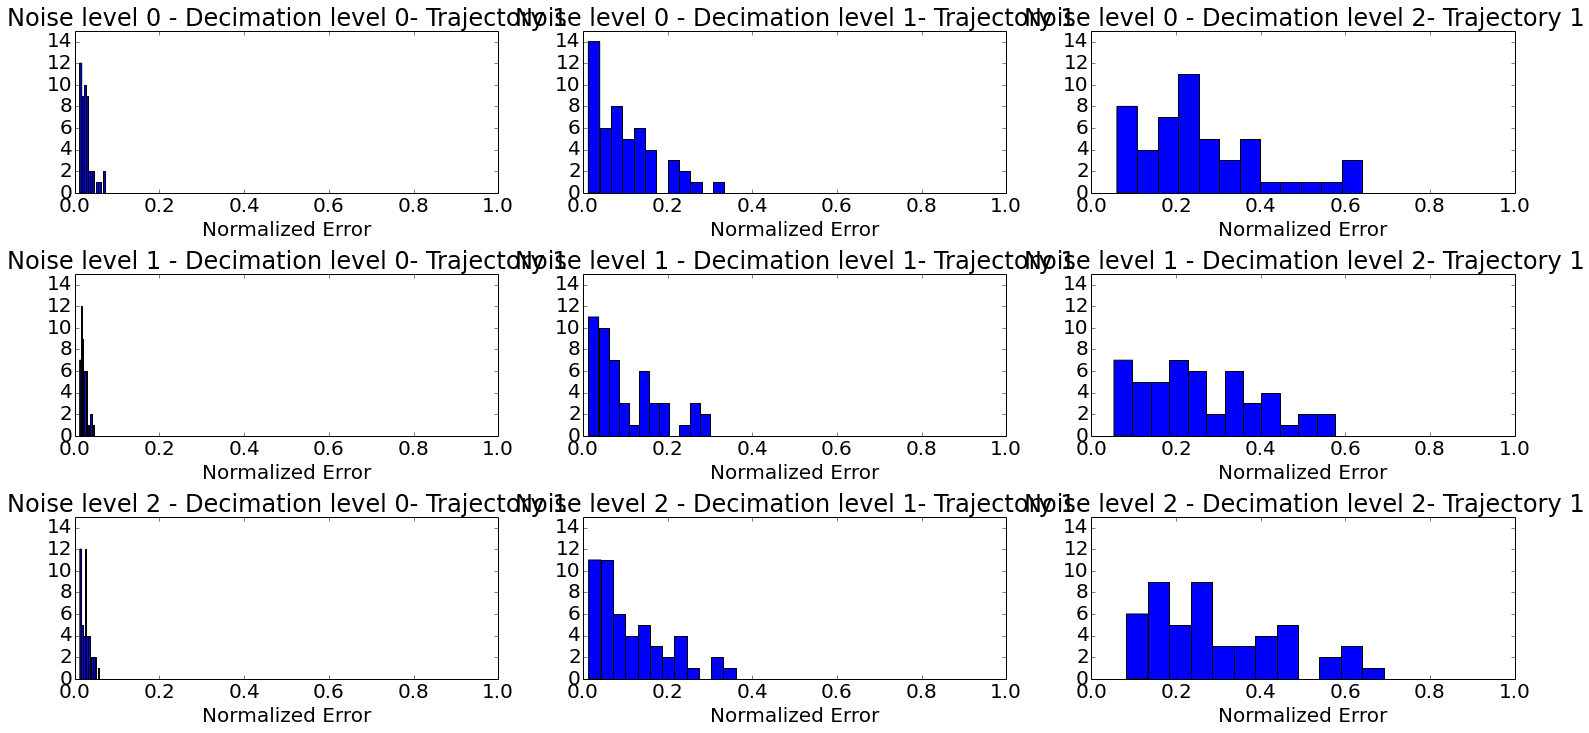

In [18]:
plt.figure(figsize =(20,10))
subplti=1

tji=1
METRIC=slf.load_from_file("./"+base_dir+"/"+sim_set+"/metric_trajectory_trajectory_"+str(tji)+".pickles")
for ni in range(3):
    for di in range(3):
        plt.subplot(3,3,subplti)
        subplti+=1
        plt.hist(METRIC[ni,di,:],bins=total_trials/4.);
        plt.xlim(0,1)
        plt.ylim(0,15)
        plt.xlabel("Normalized Error")
        plt.title("Noise level "+str(ni)+" - Decimation level "+str(di)+"- Trajectory "+str(tji))

plt.subplots_adjust(left=0, bottom=.1, right=1, top=1,wspace=.2, hspace=.5)
# plt.savefig("./"+base_dir+"/NormalizedError_All_Trajectories.pdf", bbox_inches='tight',pad_inches=1)
plt.show()

## Loads the coefficients generated by the linear regression:

In [19]:
[c_tau1,r_tau1] = slf.load_from_file("./"+base_dir+"/"+sim_set+"/coefficients_residues_tau1_08-05-15.pickle")
[c_tau2,r_tau2] = slf.load_from_file("./"+base_dir+"/"+sim_set+"/coefficients_residues_tau2_08-05-15.pickle")
r_tau1,r_tau2

(-0.011304477550689068, 0.21143562802184721)

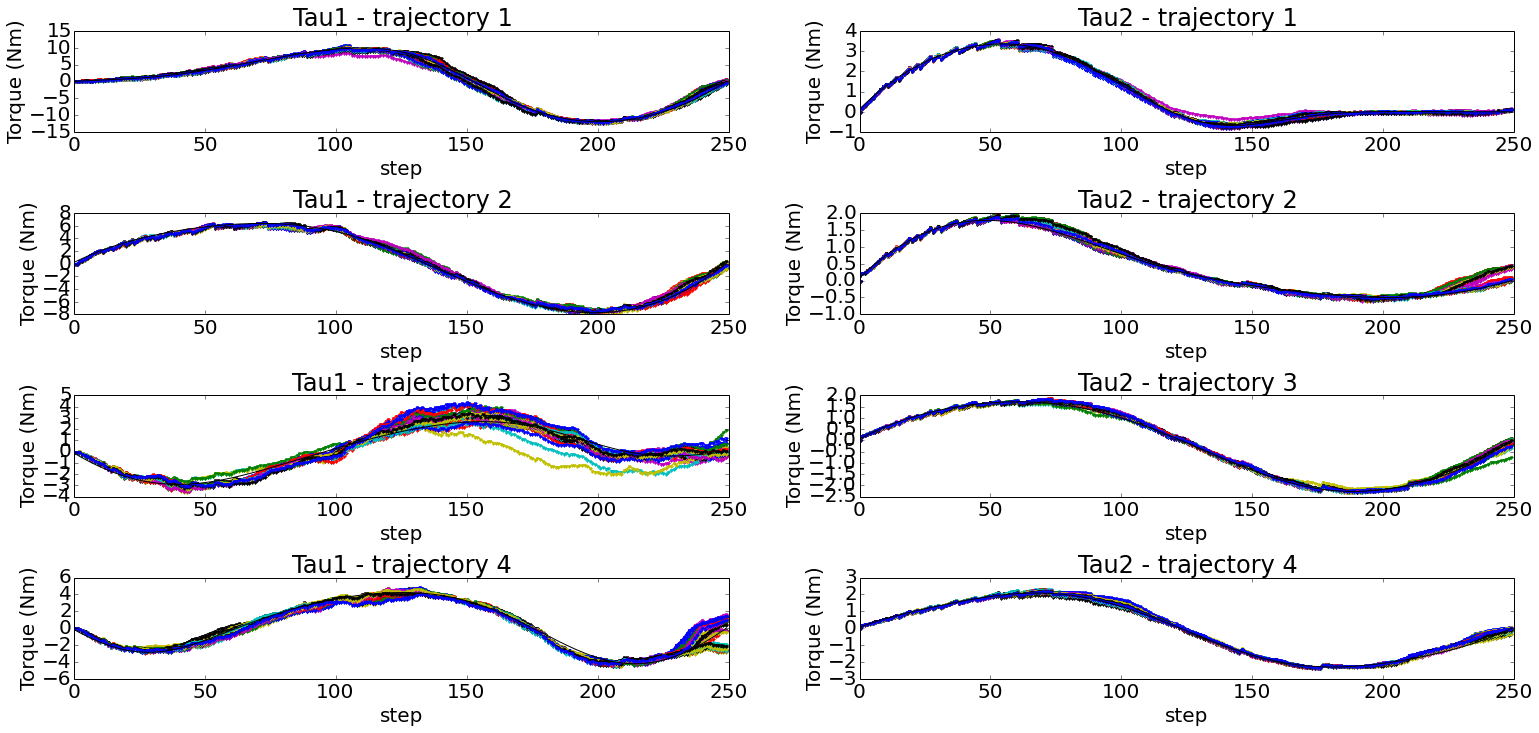

In [23]:
noiselevel=0
decimationlevel=0

plt.figure(figsize =(20,10))

subploti=1
for tji in range(1,5):
    torques_original = numpy.array([torques_all_1[(tji-1)*250:(tji)*250],torques_all_2[(tji-1)*250:(tji)*250]])
    x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji)
    ymin = numpy.array([torques_all_1.min(),torques_all_2.min()]).min()
    ymax = numpy.array([torques_all_1.max(),torques_all_2.max()]).max()

    torques_read_1=numpy.zeros((total_trials,250))
    torques_read_2=numpy.zeros((total_trials,250))


    plt.subplot(4,2,subploti)
    for run_number in range(1,total_trials+1):
        torques = slf.load_from_file("./"+base_dir+"/"+sim_set+"/torques_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
        torques_read_1[run_number-1] = numpy.copy(torques[:,0])
        plt.plot(torques[:,0],'.-',label="Tau1 Calculated")
    plt.plot(torques_original[0,:],'k-',label="Tau1 Original")
    plt.ylabel("Torque (Nm)")
    plt.xlabel("step")
    plt.title("Tau1 - trajectory " + str(tji))
    plt.xlim(0,250)
    # plt.legend()

    plt.subplot(4,2,subploti+1)
    subploti+=2
    for run_number in range(1,total_trials+1):
        torques = slf.load_from_file("./"+base_dir+"/"+sim_set+"/torques_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
        torques_read_2[run_number-1] = numpy.copy(torques[:,1])
        plt.plot(torques[:,1],'.-',label="Tau2 Calculated")
    plt.plot(torques_original[1,:],'k-',label="Tau2 Original")
    plt.xlim(0,250)
    plt.ylabel("Torque (Nm)")
    plt.xlabel("step")
    plt.title("Tau2 - trajectory " + str(tji))
    # plt.ylim(ymin,ymax)
    # plt.legend()
    
plt.subplots_adjust(left=0, bottom=.1, right=1, top=1, wspace=.2, hspace=.8)
plt.savefig("./"+base_dir+"/"+sim_set+"/readout_testing_all_"+sim_set+".pdf", bbox_inches='tight',pad_inches=1)
plt.show()

In [18]:
print "/readout_testing_all_"+sim_set+".pdf"

/readout_testing_all_set_01.pdf


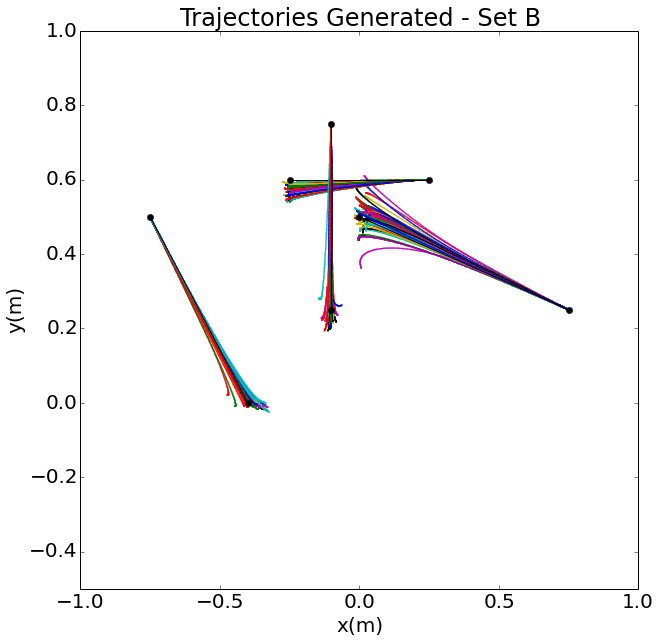

In [24]:
plt.figure(figsize =(10,10))
noiselevel=0
decimationlevel=0

for tji in range(1,5):
    x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji)
    for run_number in range(1,total_trials+1):
        teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
        H,E = joints_to_hand(teta,aparams)
        plt.plot(H[:,0],H[:,1],'.-',markersize=1)
    plt.plot([xstart,xdest],[ystart,ydest],'ko-')
    plt.xlim(numpy.array([xstart,xdest]).min()-0.1,numpy.array([xstart,xdest]).max()+0.1)
    plt.ylim(numpy.array([ystart,ydest]).min()-0.1,numpy.array([ystart,ydest]).max()+0.1)

plt.title("Trajectories Generated - " + sim_set_name)
plt.xlabel("x(m)")
plt.ylabel("y(m)")

plt.xlim(-1,1)
plt.ylim(-.5,1)
plt.savefig("./"+base_dir+"/"+sim_set+"/All_Trajectories_g1_"+sim_set+".pdf", bbox_inches='tight',pad_inches=1)
plt.show()